In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 23.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
import shap  # paquete utilizado para calcular los valores shap

# Análisis del dataset (EDA)

Este dataset consiste en estadísticas de todos los partidos jugados en el Mundial de Fútbol del 2018, donde se intentara predecir si el jugador del partido pertenece al equipo "Team". El mismo fue obtenido del siguiente kaggle:https://www.kaggle.com/datasets/mathan/fifa-2018-match-statistics?datasetId=32736&sortBy=dateRun&tab=bookmarked

En primer lugar, importamos el dataset

In [ ]:
data = pd.read_csv('/content/FIFA 2018 Statistics.csv')
data.sample(3)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
109,03-07-2018,Switzerland,Sweden,0,63,18,4,5,9,11,0,12,2,84,599,103,13,2,0,1,No,NaN,Round of 16,No,0,NaN,NaN
58,24-06-2018,England,Panama,6,58,12,7,3,2,3,3,13,1,94,593,99,14,1,0,0,Yes,8.0,Group Stage,No,0,NaN,NaN
52,23-06-2018,Belgium,Tunisia,5,52,23,12,8,3,5,3,16,3,84,468,104,12,0,0,0,Yes,6.0,Group Stage,No,0,NaN,NaN


Como mencionamos, la predicción consistira en determinar si el jugador del partido pertenecio al equipo "Team", por ejemplo acá visualizamos los encuentros donde Argentina es el equipo "Team"

In [ ]:
data[(data.Team == 'Argentina')]

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
10,16-06-2018,Argentina,Iceland,1,72,26,7,9,10,10,0,15,2,92,718,101,10,0,0,0,No,19.0,Group Stage,No,0,NaN,NaN
44,21-06-2018,Argentina,Croatia,0,58,10,3,3,4,5,3,26,2,81,505,101,15,3,0,0,No,NaN,Group Stage,No,0,NaN,NaN
77,26-06-2018,Argentina,Nigeria,2,66,8,4,3,1,5,2,20,2,84,565,101,15,3,0,0,Yes,14.0,Group Stage,No,0,NaN,NaN
97,30-06-2018,Argentina,France,3,59,9,4,1,4,4,1,21,0,86,547,96,15,5,0,0,No,41.0,Round of 16,No,0,NaN,NaN


Descripcion de las columnas del dataset:

- Date: Día del partido
- Team: Equipo a determinar si el jugador del partido pertenece o no
- Opponent: Oponente de "team"
- Goal Scored: Numero de goles combertidos por Team
- Ball Possession %: Cantidad de tiempo que la pelota fue controlada por Team
- Attempts: Numero de intentos de realizar un gol
- On-Target: Tiros al arco
- Off-Target: Tiros fuera del arco
- Blocked: Cantidad de intentos bloqueados por el oponente
- Corners: Cantiad de corners para Team
- Offsides: Cantidad de offsides
- Free Kicks: Cantidad de tiros libres
- Saves: Cantidad de atajadas por el arquero
- Pass Accuracy %: Cantidad de pases acertados a compañeros del mismo equipo
- Passes: Cantidad de pases realizados por el equipo
- Distance Covered (Kms): Distancia recorrida por los integrantes del equipo
- Fouls Committed: Cantidad de fouls cometidos por el equipo
- Yellow Card: Cantidad de amarillas recibidas
- Yellow & Red: Cantidad de advertencias de amarillas y rojas
- Red: Cantidad de rojas recibidas
- Man of the Match: Si el equipo Team tuvo al jugador del partido
- 1st Goal: Cuando se combirtio el primer gol
- Round: Etapa del encuentro
- PSO: Hubo tiros penales?
- Goals in PSO: Goles de penales
- Own goals: Cantidad de goles encontra
- Own goal Time: Cuando fue el gol encontra



In [ ]:
data.columns.to_list()

['Date',
 'Team',
 'Opponent',
 'Goal Scored',
 'Ball Possession %',
 'Attempts',
 'On-Target',
 'Off-Target',
 'Blocked',
 'Corners',
 'Offsides',
 'Free Kicks',
 'Saves',
 'Pass Accuracy %',
 'Passes',
 'Distance Covered (Kms)',
 'Fouls Committed',
 'Yellow Card',
 'Yellow & Red',
 'Red',
 'Man of the Match',
 '1st Goal',
 'Round',
 'PSO',
 'Goals in PSO',
 'Own goals',
 'Own goal Time']

Realizamos un análisis univariado de nuestro dataset

In [ ]:
data.describe()

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,1st Goal,Goals in PSO,Own goals,Own goal Time
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,94.000000,128.000000,12.0,12.000000
mean,1.320312,49.992188,12.593750,3.914062,5.273438,3.359375,4.718750,1.343750,14.890625,2.726562,82.554688,462.648438,106.664062,13.546875,1.695312,0.015625,0.015625,39.457447,0.203125,1.0,45.833333
std,1.156519,10.444074,5.245827,2.234403,2.409675,2.403195,2.446072,1.193404,4.724262,2.049447,5.933766,151.186311,11.749537,4.619131,1.325454,0.124507,0.124507,24.496506,0.807049,0.0,29.978275
min,0.000000,25.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,67.000000,189.000000,80.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,12.000000
25%,0.000000,42.000000,9.000000,2.000000,4.000000,1.750000,3.000000,0.000000,11.000000,1.000000,79.000000,351.000000,101.000000,10.000000,1.000000,0.000000,0.000000,18.250000,0.000000,1.0,21.750000
50%,1.000000,50.000000,12.000000,3.500000,5.000000,3.000000,5.000000,1.000000,15.000000,2.000000,83.000000,462.000000,104.500000,13.000000,2.000000,0.000000,0.000000,39.000000,0.000000,1.0,35.000000
75%,2.000000,58.000000,15.000000,5.000000,7.000000,4.000000,6.000000,2.000000,18.000000,4.000000,87.000000,555.250000,109.000000,16.000000,2.000000,0.000000,0.000000,54.750000,0.000000,1.0,75.750000
max,6.000000,75.000000,26.000000,12.000000,11.000000,10.000000,11.000000,5.000000,26.000000,9.000000,94.000000,1137.000000,148.000000,25.000000,6.000000,1.000000,1.000000,90.000000,4.000000,1.0,90.000000


Generamos una nueva columna que tenga nuestro valor target como numérico

In [ ]:
data['MOTM_BINARY'] = data['Man of the Match'].map({'Yes': 1, 'No': 0})
data['MOTM_BINARY']

Realizamos un analisis bivariado de nuesto dataset para esto utilizaremos las siguientes herramientas
- Pearson
- Pairplot

Realizamos un heatmap para comprender la correlación entre nuestras variables

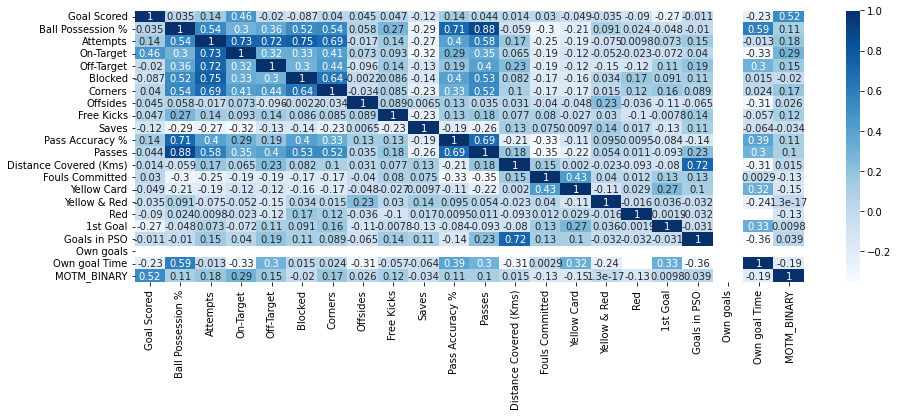

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.heatmap(data[[
 'Goal Scored',
 'Ball Possession %',
 'Attempts',
 'On-Target',
 'Off-Target',
 'Blocked',
 'Corners',
 'Offsides',
 'Free Kicks',
 'Saves',
 'Pass Accuracy %',
 'Passes',
 'Distance Covered (Kms)',
 'Fouls Committed',
 'Yellow Card',
 'Yellow & Red',
 'Red',
 'Man of the Match',
 '1st Goal',
 'Round',
 'PSO',
 'Goals in PSO',
 'Own goals',
 'Own goal Time',
 'MOTM_BINARY']].corr(), cmap='Blues', annot=True)


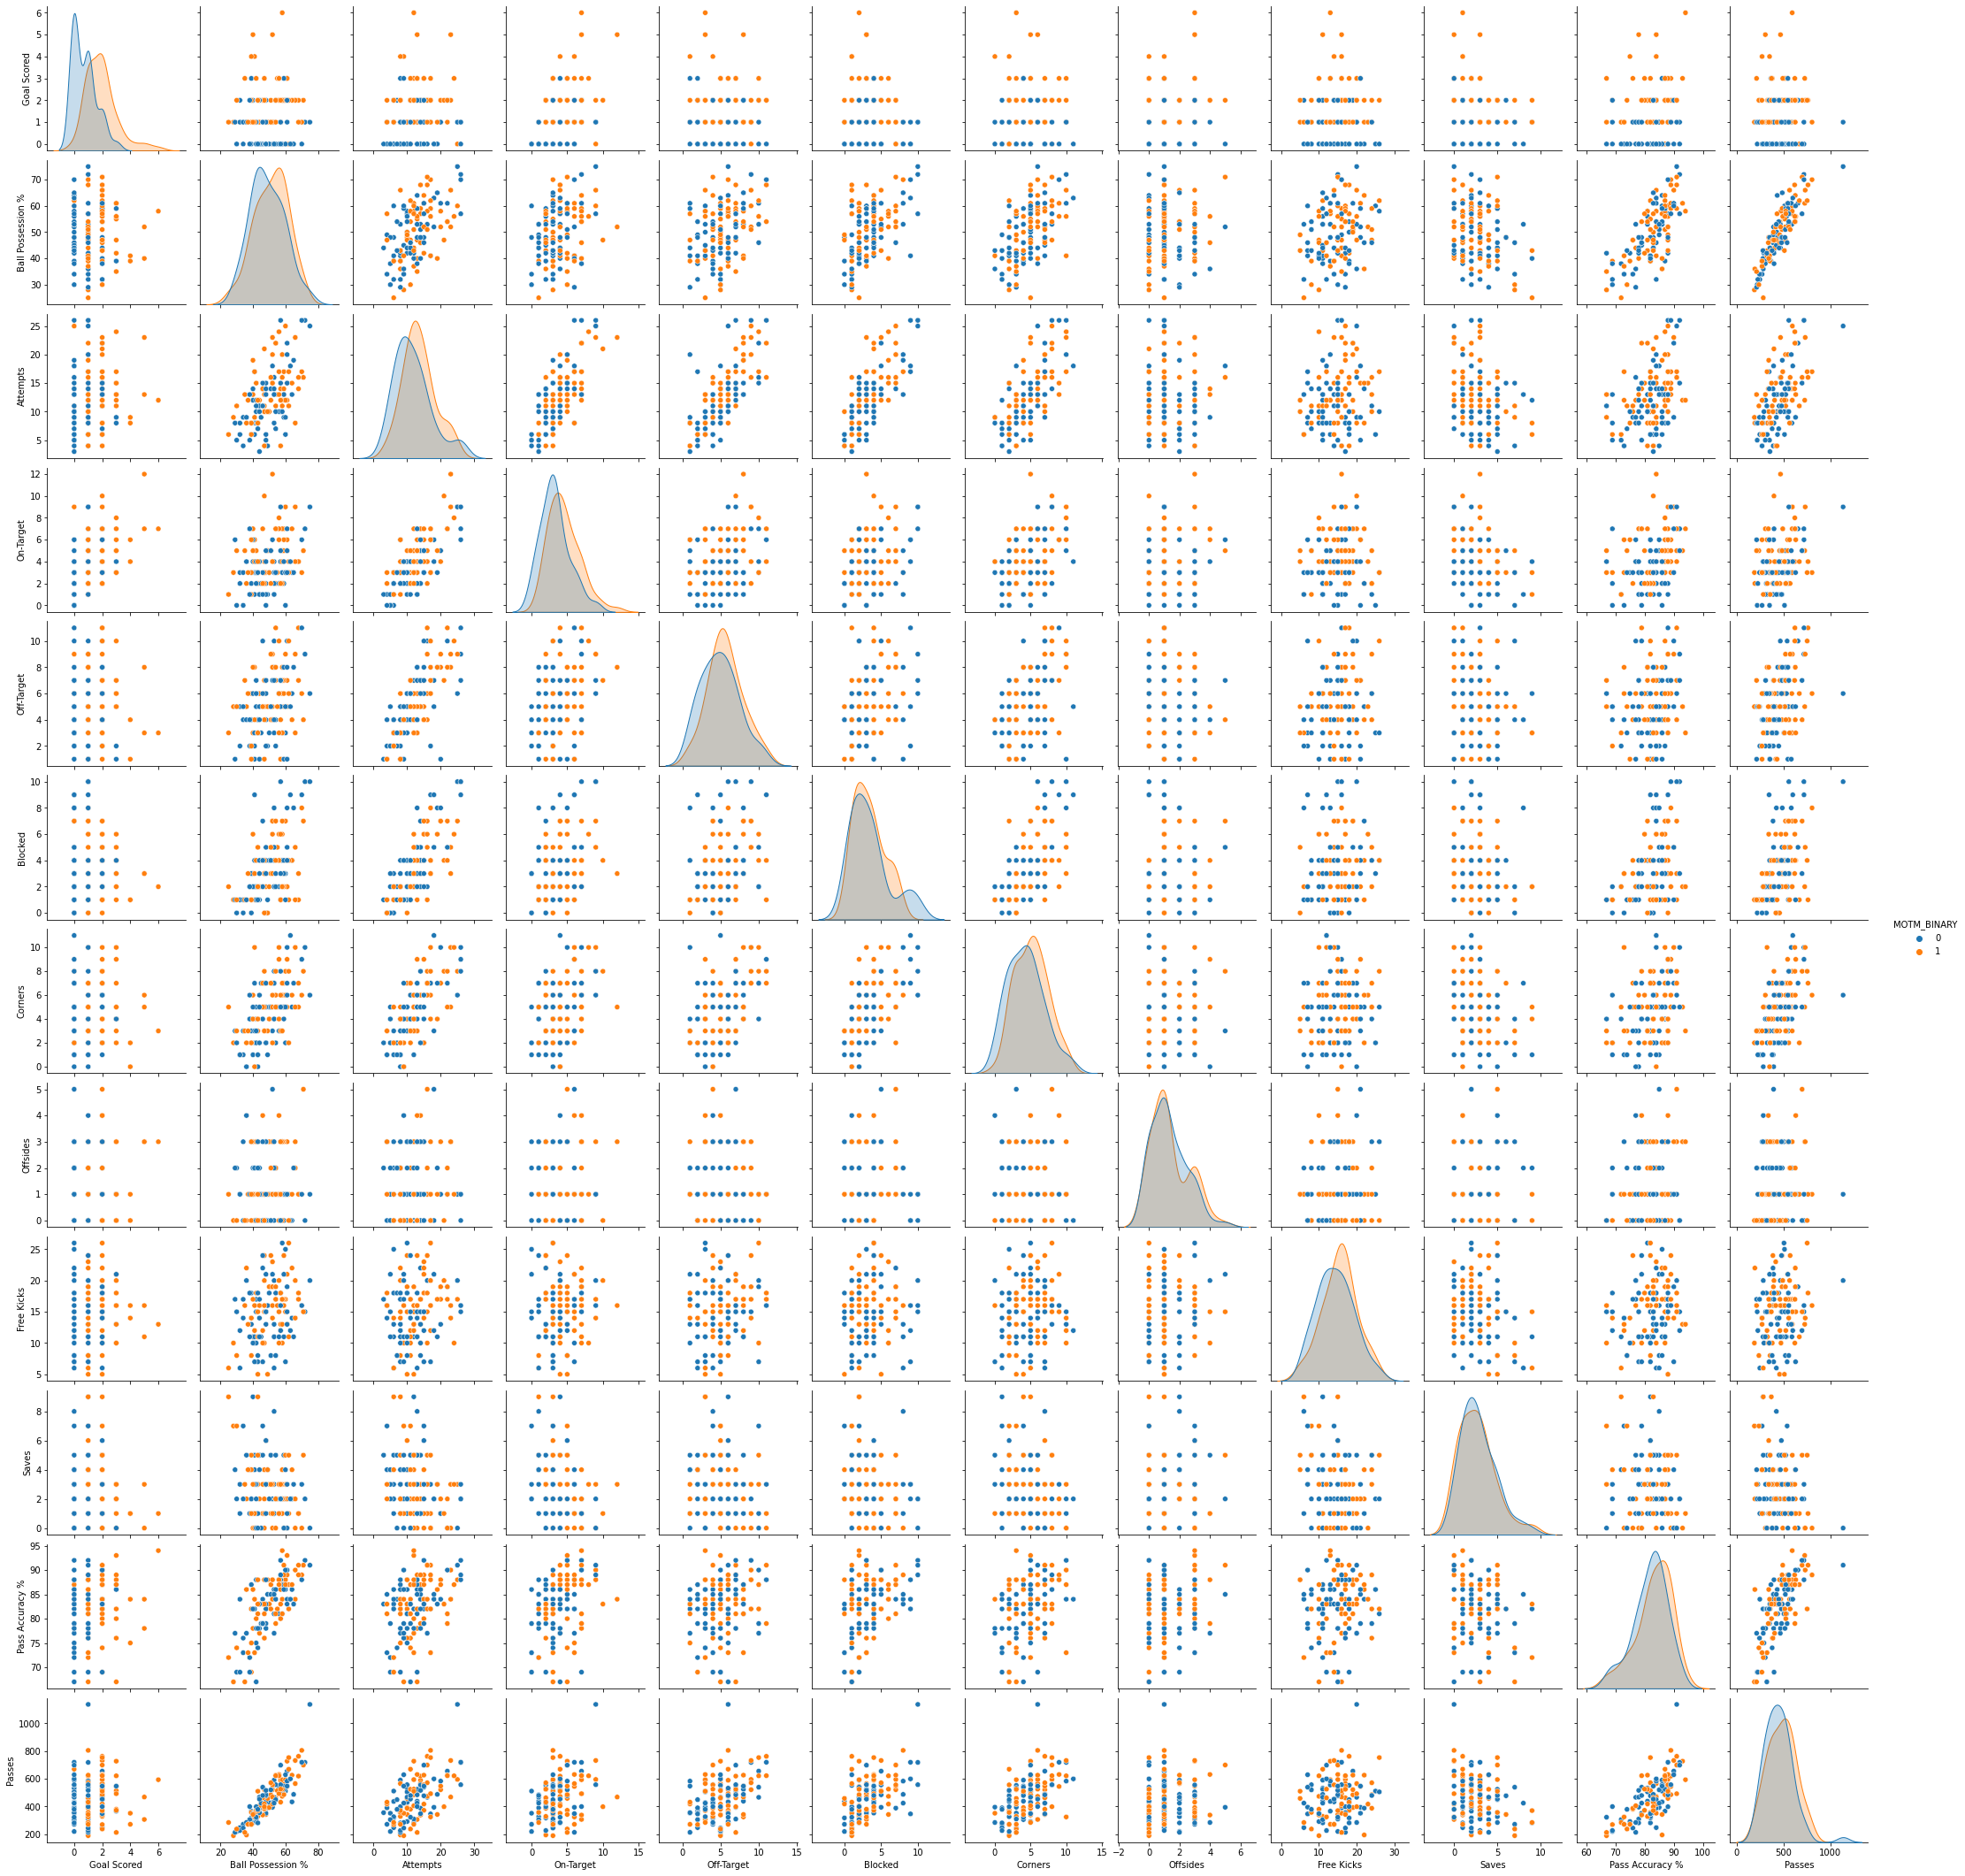

In [ ]:
sns.pairplot(data=data[['Goal Scored',
 'Ball Possession %',
 'Attempts',
 'On-Target',
 'Off-Target',
 'Blocked',
 'Corners',
 'Offsides',
 'Free Kicks',
 'Saves',
 'Pass Accuracy %',
 'Passes',
 'MOTM_BINARY'
 ]], hue = 'MOTM_BINARY', diag_kind='kde')

# Predicción

In [ ]:
ds_fifa = data.loc[:, data.columns != 'MOTM_BINARY']

y = (ds_fifa['Man of the Match'] == "Yes") 
feature_names = [i for i in ds_fifa.columns if ds_fifa[i].dtype in [np.int64, np.int64]]
X = ds_fifa[feature_names]
X.sample(10)

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
5,1,36,8,2,5,1,2,0,22,2,86,194,100,14,3,0,0,0
69,2,32,6,3,2,1,1,1,6,1,84,247,111,17,6,0,0,0
37,0,53,8,3,3,2,4,2,11,3,86,590,100,13,0,0,0,0
103,1,46,15,3,10,2,4,0,7,7,79,539,135,19,1,0,0,2
114,1,57,26,9,7,10,8,1,16,2,89,557,104,14,2,0,0,0
26,1,41,6,1,3,2,2,2,11,5,82,326,103,14,0,0,0,0
102,1,54,22,7,8,7,5,2,19,2,81,626,132,5,0,0,0,3
127,2,61,15,3,8,4,6,1,15,3,83,547,100,13,1,0,0,0
52,5,52,23,12,8,3,5,3,16,3,84,468,104,12,0,0,0,0
87,2,40,14,6,6,2,5,1,10,1,82,348,103,14,3,0,0,0


Para el análisis de Shap values, nos quedaremos con los casos donde el equipo tuvo la figura del partido para poder ver y explicar cuales son las variables que más contribuyen a que un equipo obtenga el "Man of the Match"

Además, nos quedaremos con las variables numéricas ya que el método shap no admite variables categóricas (al menos sin preprocesamiento).

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [ ]:
my_model = RandomForestClassifier(random_state=32).fit(train_X, train_y)
my_model

RandomForestClassifier(random_state=32)

In [ ]:
val_X.head(7)


,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
121,0,60,9,3,5,1,5,1,7,4,90,629,102,16,3,0,0,0
104,2,47,21,10,7,4,8,0,20,1,83,398,92,6,2,0,0,0
55,2,59,13,5,6,2,5,0,24,5,89,485,97,7,0,0,0,0
56,2,71,16,5,4,7,8,5,15,5,91,699,111,12,0,1,0,0
33,1,53,13,1,8,4,4,0,11,1,81,438,110,10,1,0,0,0
118,2,38,13,7,4,2,6,1,18,1,69,399,148,25,1,0,0,3
122,2,54,22,7,11,4,8,1,17,0,79,622,143,23,2,0,0,0


In [ ]:
data.columns.to_list()

# Shapley values

**El método Explainer**

Se puede utilizar para explicar cualquier tipo de modelo que querramos usar. Redes neuronales, árboles de decisión, modelos lineales, etc.

Este algoritmo fue creado por Scott Lundherg y Su-In Lee.

En python contamos con la librería SHAP de donde utilizaremos todos sus métodos y funciones para poder interpretar los modelos de Machine Learning.

La documentacion de la librería la podemos encontrar en : https://shap.readthedocs.io/en/latest/index.html

In [ ]:
# Creamos el objeto que calculo los valores shap
explainer = shap.Explainer(my_model)

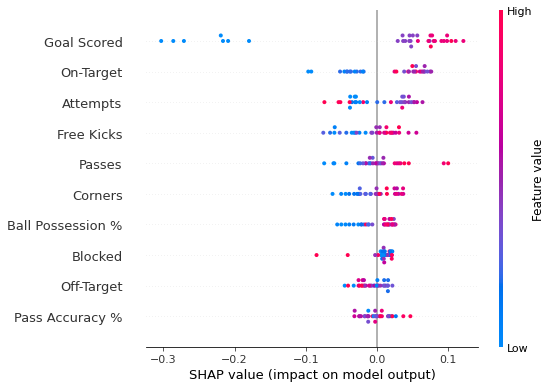

In [ ]:
shap_values = explainer.shap_values(val_X)
shap.summary_plot(shap_values[1], val_X, max_display=10)

Tomamos una unica fila para poder comprender como se descompone la importancia de cada valor

In [ ]:
row_to_show = 6
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction

Goal Scored                 2
Ball Possession %          54
Attempts                   22
On-Target                   7
Off-Target                 11
Blocked                     4
Corners                     8
Offsides                    1
Free Kicks                 17
Saves                       0
Pass Accuracy %            79
Passes                    622
Distance Covered (Kms)    143
Fouls Committed            23
Yellow Card                 2
Yellow & Red                0
Red                         0
Goals in PSO                0
Name: 122, dtype: int64

In [ ]:
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
data_for_prediction_array

array([[  2,  54,  22,   7,  11,   4,   8,   1,  17,   0,  79, 622, 143,
         23,   2,   0,   0,   0]])

In [ ]:
my_model.predict_proba(data_for_prediction_array)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[0.31, 0.69]])

In [ ]:
# Calculamos los valores shap
shap_values_single_row = explainer.shap_values(data_for_prediction)
shap_values_single_row

[array([-0.08652661, -0.02014391,  0.00696484, -0.01350636,  0.02191543,
        -0.01133292, -0.04250597,  0.00539996, -0.01888367,  0.00032631,
         0.00508625, -0.00264475,  0.00873456, -0.03699351, -0.00504075,
        -0.00039037, -0.00079172,  0.00158319]),
 array([ 0.08652661,  0.02014391, -0.00696484,  0.01350636, -0.02191543,
         0.01133292,  0.04250597, -0.00539996,  0.01888367, -0.00032631,
        -0.00508625,  0.00264475, -0.00873456,  0.03699351,  0.00504075,
         0.00039037,  0.00079172, -0.00158319])]

In [ ]:
explainer.expected_value[1]

0.5012500000000001

In [ ]:
shap_values_single_row[1]

array([ 0.08652661,  0.02014391, -0.00696484,  0.01350636, -0.02191543,
        0.01133292,  0.04250597, -0.00539996,  0.01888367, -0.00032631,
       -0.00508625,  0.00264475, -0.00873456,  0.03699351,  0.00504075,
        0.00039037,  0.00079172, -0.00158319])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_single_row[1], data_for_prediction)